In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from database import (
    engine_DW,
    engine_staging,
    db_staging,
    db_DW,

    table_staging_marine_name,
    table_staging_meteo_name,

    table_facts_marine_name,
    table_facts_meteo_name,

    table_dim_station_name,
    table_dim_time_name)

from imports import *
from functions import *

%load_ext autoreload
%autoreload 1

Connexion r√©ussie √† la base de donn√©es DW!
Connexion r√©ussie √† la base de donn√©es Staging!
Tables cr√©√©es avec succ√®s!


# Extraction

Get Available Stations ID List

In [3]:
# get all stations and some metadata as a Pandas DataFrame
stations_df = api.stations()
# parse the response as a dictionary
stations_df = api.stations(as_df=True)

print(len(stations_df))

146


Filter Buoys by Remarks

In [4]:
access_error_url_list = []

# Liste de mots √† rechercher dans la colonne "Remark"
blacklist = ["Failure", "ceased", "failed", "recovered", "stopped", 'adrift']
stations_id_set = set()

print(f'Avant Filtre: {stations_df.shape[0]}')

# Liste pour collecter les indices √† supprimer
indices_a_supprimer = []

# Parcours des lignes de la DataFrame
for idx, row in stations_df.iterrows():
    # Creation de l'url via la station ID
    station_id = row["Station"]
    url = r"https://www.ndbc.noaa.gov/station_page.php?station="+str(station_id)
    #creation
    station_Location = row["Hull No./Config and Location"]  # Extraire la valeur de la cellule pour chaque ligne
    
    # Extraction du nom de la station si un ")" est trouv√©
    if ")" in station_Location:
        station_name = station_Location.split(')')[1].rstrip(" )")  # On enl√®ve l'espace et la parenth√®se en fin de cha√Æne
    else:
        station_name = station_Location.strip()  # Si pas de ")", on garde toute la cha√Æne

    station_name = station_name.rstrip(" )").replace("(", "").replace(")", "").strip()

    # Nettoyage final pour enlever toute parenth√®se ou espace en fin de nom
    station_name = station_name.rstrip(" )")

    # V√©rifier si "Remark" n'est pas NaN et si un des √©l√©ments de blacklist est dans "Remark"
    if isinstance(row["Remark"], str) and any(blacklist_word.lower() in row["Remark"].lower() for blacklist_word in blacklist):
        # Ajouter l'index √† la liste
        indices_a_supprimer.append(idx)
        url = get_buoy_url(station_id)
        access_error_url_list.append(url)
    else:
        pass
# Supprimer les lignes apr√®s la boucle
stations_df.drop(index=indices_a_supprimer, inplace=True)

print("\nüåä Bou√©es rejet√©es (URLs):")
for url in access_error_url_list:
    print(url)

print(f'Apr√®s Filtre: {stations_df.shape[0]}')

Avant Filtre: 146

üåä Bou√©es rejet√©es (URLs):
https://www.ndbc.noaa.gov/station_page.php?station=41001
https://www.ndbc.noaa.gov/station_page.php?station=41009
https://www.ndbc.noaa.gov/station_page.php?station=41025
https://www.ndbc.noaa.gov/station_page.php?station=41041
https://www.ndbc.noaa.gov/station_page.php?station=41048
https://www.ndbc.noaa.gov/station_page.php?station=42039
https://www.ndbc.noaa.gov/station_page.php?station=42040
https://www.ndbc.noaa.gov/station_page.php?station=42055
https://www.ndbc.noaa.gov/station_page.php?station=44005
https://www.ndbc.noaa.gov/station_page.php?station=44008
https://www.ndbc.noaa.gov/station_page.php?station=44017
https://www.ndbc.noaa.gov/station_page.php?station=44018
https://www.ndbc.noaa.gov/station_page.php?station=44066
https://www.ndbc.noaa.gov/station_page.php?station=45001
https://www.ndbc.noaa.gov/station_page.php?station=45002
https://www.ndbc.noaa.gov/station_page.php?station=45003
https://www.ndbc.noaa.gov/station_page

Get HTML from buoys that failed the test

In [5]:
DICT_SECTIONS = {}

for url in access_error_url_list:
    try:
        # Extraction de l'identifiant de la bou√©e depuis l'URL
        buoy_id = url.split("=")[1]
        DICT_SECTIONS[buoy_id] = {}

        # Requ√™te HTTP vers la page de la bou√©e
        response = requests.get(url, timeout=5)
        soup = BeautifulSoup(response.content, "html.parser")

        # Recherche de la section sp√©cifique contenant les m√©tadonn√©es
        section_metadata = soup.find("section", id="stationmetadata", class_="metadata")
        
        if section_metadata:
            print(f"‚úÖ Metadata trouv√©e pour {buoy_id}")
            DICT_SECTIONS[buoy_id]["html"] = section_metadata
        else:
            print(f"‚ùå Aucune metadata trouv√©e pour {buoy_id}")

    except Exception as e:
        print(f"‚ùå Erreur pour {buoy_id} : {str(e)}")



‚úÖ Metadata trouv√©e pour 41001
‚úÖ Metadata trouv√©e pour 41009
‚úÖ Metadata trouv√©e pour 41025
‚úÖ Metadata trouv√©e pour 41041
‚úÖ Metadata trouv√©e pour 41048
‚úÖ Metadata trouv√©e pour 42039
‚úÖ Metadata trouv√©e pour 42040
‚úÖ Metadata trouv√©e pour 42055
‚úÖ Metadata trouv√©e pour 44005
‚úÖ Metadata trouv√©e pour 44008
‚úÖ Metadata trouv√©e pour 44017
‚úÖ Metadata trouv√©e pour 44018
‚úÖ Metadata trouv√©e pour 44066
‚úÖ Metadata trouv√©e pour 45001
‚úÖ Metadata trouv√©e pour 45002
‚úÖ Metadata trouv√©e pour 45003
‚úÖ Metadata trouv√©e pour 45004
‚úÖ Metadata trouv√©e pour 45005
‚úÖ Metadata trouv√©e pour 45006
‚úÖ Metadata trouv√©e pour 45007
‚úÖ Metadata trouv√©e pour 45008
‚úÖ Metadata trouv√©e pour 45012
‚úÖ Metadata trouv√©e pour 46002
‚úÖ Metadata trouv√©e pour 46005
‚úÖ Metadata trouv√©e pour 46006
‚úÖ Metadata trouv√©e pour 46011
‚úÖ Metadata trouv√©e pour 46012
‚úÖ Metadata trouv√©e pour 46013
‚úÖ Metadata trouv√©e pour 46015
‚úÖ Metadata trouv√©e pour 46026
‚úÖ Metada

In [6]:

# Choisir un buoy_id au hasard dans le dictionnaire
random_buoy_id = random.choice(list(DICT_SECTIONS.keys()))
section_html = DICT_SECTIONS[random_buoy_id].get("html")

# URL de base pour les images
base_url = f"https://www.ndbc.noaa.gov/station_page.php?station={random_buoy_id}"

if section_html:
    # Convertir en objet BeautifulSoup si ce n‚Äôest pas d√©j√† fait
    soup = BeautifulSoup(str(section_html), "html.parser")

    # Convertir tous les liens <img src="..."> en absolu
    for img in soup.find_all("img"):
        if img.has_attr("src"):
            img["src"] = urljoin(base_url, img["src"])

    print(f"üéØ Bou√©e s√©lectionn√©e : {random_buoy_id}")
    display(HTML(str(soup)))
else:
    print(f"‚ö†Ô∏è Pas de contenu HTML pour la bou√©e {random_buoy_id}")


üéØ Bou√©e s√©lectionn√©e : 46011


In [7]:
stations_df.head()

Station Hull No./Config and Location Location Lat/Long Wind Speed  \
2    41004            3DV02 (SC) Edisto     32.50N 79.08W        100   
3    41008         3D36 (SC) Grays Reef     31.40N 80.85W        100   
11   41044       3D70 (SC) Ne St Martin     21.57N 58.62W        100   
12   41046      3DV09 (SC) East Bahamas     23.85N 68.33W         86   
15   41049     3DV17 (SC) South Bermuda     27.50N 62.27W        100   

   Wind Direction Sea Level Pressure Wave Height Dominant Period Air Temp  \
2             100                100         100             100      100   
3             100                100         100             100      100   
11            100                100         100             100      100   
12             86                 86          85              85       86   
15            100                100         100             100      100   

   Water Temp Dew Point                                   Remark  
2          97       100                Dewpoint is intermittent.  
3          98       100  All data is intermittent after 8/18/23.  
11         98       100                                      NaN  
12         84        86               New buoy deployed 4/22/25.  
15         98       100                                      NaN

Build Buoys_datas Dict

In [8]:
# Dictionnaire pour stocker les DataFrames, cl√© : ID de la bou√©e, valeur : DataFrame
buoy_datas = {}
buoy_list = []

# Parcours de chaque bou√©e dans stations_df
for index, row in stations_df.iterrows():
    buoy_id = row['Station']
    metadata = get_station_metadata(buoy_id)

    # ‚úÖ R√©cup√©rer les donn√©es sous forme de dictionnaire
    buoy_info = parse_buoy_json(metadata)

    # ‚úÖ Stocker directement les donn√©es dans buoy_datas
    buoy_datas[buoy_id] = buoy_info
    buoy_list.append(buoy_id)

# Affichage du nombre de bou√©es r√©ussies et √©chou√©es
print(f"Nombre de bou√©es trait√©es : {len(buoy_datas)}\n")

# Afficher le contenu de buoy_datas

first_key =next(iter(buoy_datas))
first_key
buoy_datas[first_key]


üîç D√©but du parsing de la bou√©e...
üåç Zone de la station : edisto
üÜî Station ID : 41004
‚úÖ Coordonn√©es extraites : Latitude = 32.50N, Longitude = 79.10W
üåä Water Depth : 35 m
üå°Ô∏è Sea Temp Depth : 1.5
üå¨Ô∏è Barometer Elevation (m): 2.7
üí® Anemometer Height : 4.1
üå§Ô∏è Air Temp Height : 3.7
üîó URL de la bou√©e : https://www.ndbc.noaa.gov/station_page.php?station=41004
‚úÖ Parsing termin√© !


üîç D√©but du parsing de la bou√©e...
üåç Zone de la station : grays reef
üÜî Station ID : 41008
‚úÖ Coordonn√©es extraites : Latitude = 31.40N, Longitude = 80.87W
üåä Water Depth : 16 m
üå°Ô∏è Sea Temp Depth : 2
üå¨Ô∏è Barometer Elevation (m): 2.4
üí® Anemometer Height : 3.8
üå§Ô∏è Air Temp Height : 3.4
üîó URL de la bou√©e : https://www.ndbc.noaa.gov/station_page.php?station=41008
‚úÖ Parsing termin√© !


üîç D√©but du parsing de la bou√©e...
üåç Zone de la station : ne st martin
üÜî Station ID : 41044
‚úÖ Coordonn√©es extraites : Latitude = 21.58N, Longitude =

{'station_zone': 'edisto',
 'lat_buoy': '32.50N',
 'lon_buoy': '79.10W',
 'Water_depth': '35 m',
 'sea_temp_depth': '1.5',
 'Barometer_elevation': '2.7',
 'Anemometer_height': '4.1',
 'Air_temp_height': '3.7',
 'url': 'https://www.ndbc.noaa.gov/station_page.php?station=41004'}

In [9]:
from IPython.display import display, HTML

import folium

# Liste pour stocker les coordonn√©es
coordinates = []

# Remplir la liste avec les coordonn√©es converties
for buoy_id, value in buoy_datas.items():
    Water_depth = value["Water_depth"]
    station_zone = value["station_zone"]
    lat = value["lat_buoy"]
    lon = value["lon_buoy"]
    
    lat, lon = convert_to_decimal(lat, lon)
    coordinates.append((lat, lon, Water_depth, station_zone, buoy_id))

# Calcul du centre de la carte
avg_lat = sum(coord[0] for coord in coordinates) / len(coordinates)
avg_lon = sum(coord[1] for coord in coordinates) / len(coordinates)

# Cr√©ation de la carte avec zoom 2.5, sans attribution visible
map_center = folium.Map(
    location=[avg_lat, avg_lon],
    zoom_start=2.5,
    tiles=None
)

# Ajouter les tuiles Esri sans attribution visible
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="&nbsp;",  # Astuce pour √©viter l'affichage de l'attribution
    name="Esri Imagery",
    control=False
).add_to(map_center)

# Ajouter les marqueurs
for lat, lon, Water_depth, station_zone, buoy_id in coordinates:
    popup = folium.Popup(f"ID: {buoy_id}<br>Zone: {station_zone}<br>Water Depth: {Water_depth} meters", max_width=300)
    folium.Marker([lat, lon], popup=popup).add_to(map_center)

# CSS pour masquer l'attribution
hide_leaflet_css = """
<style>
.leaflet-control-attribution {
    display: none !important;
}
</style>
"""

# Injecter le CSS et afficher la carte
display(HTML(hide_leaflet_css))
display(map_center)


Collecte des donn√©es marines et m√©t√©os

In [10]:
# üöÄ D√©marrage du processus
print("\nüöÄ D√©marrage du processus de collecte des donn√©es...\n")

# Initialisation des compteurs
marine_data_collected_successfully = marine_data_collected_failed = 0
meteo_data_collected_successfully = meteo_data_collected_failed = 0

success = False
total_stations = stations_df.shape[0]
count = 0

# üîÑ Parcours des bou√©es / stations
for idx, row in stations_df.iterrows():
    buoy_id = row["Station"]

    ######### üåä MARINE DATA #########
    try:
        df_marine = NDBC.realtime_observations(buoy_id)
        if df_marine is None or df_marine.empty:
            marine_data_collected_failed += 1
            continue

        marine_data_collected_successfully += 1
    except Exception as e:
        print(f"‚ö†Ô∏è Erreur collecte marine {buoy_id}: {e}")
        marine_data_collected_failed += 1
        continue

    # Ajout des m√©tadonn√©es
    try:
        buoy_info = buoy_datas.get(buoy_id, {})
        Lat, Lon = buoy_info.get('lat_buoy'), buoy_info.get('lon_buoy')
        if Lat is None or Lon is None:
            raise ValueError(f"Donn√©es manquantes pour {buoy_id}")

        df_marine['Lat'] = Lat
        df_marine['Lon'] = Lon
        df_marine['Water_depth'] = buoy_info.get('Water_depth', None)
        df_marine.columns = ['Datetime' if 'date' in col.lower() or 'time' in col.lower() else col for col in df_marine.columns]
        df_marine['Datetime'] = df_marine['Datetime'].dt.tz_localize(None)

        buoy_datas[buoy_id]["Marine"] = df_marine

        station_zone = safe_get(parse_buoy_json(get_station_metadata(buoy_id)), "station_zone")
        Bronze_Marine_table_Name = f"br_{buoy_id}_marine_{station_zone}".replace('.', '_').replace('-', '_').replace(' ', '_').lower()

    except Exception as e:
        print(f"‚ö†Ô∏è Erreur m√©tadonn√©es marine {buoy_id}: {e}")
        marine_data_collected_failed += 1
        continue

    ######### ‚õÖ METEO DATA #########
    try:
        df_meteo = meteo_api_request([Lat, Lon])
        if df_meteo is None or df_meteo.empty:
            meteo_data_collected_failed += 1
            continue
        
        rename_columns(df_meteo, {'date':'Datetime'})
        df_meteo.columns = ['Datetime' if 'date' in col.lower() or 'time' in col.lower() else col for col in df_meteo.columns]
        df_meteo['Datetime'] = df_meteo['Datetime'].dt.tz_localize(None)
    
        buoy_datas[buoy_id]["Meteo"] = df_meteo
        meteo_data_collected_successfully += 1
    except Exception as e:
        print(f"‚ö†Ô∏è Erreur collecte m√©t√©o {buoy_id}: {e}")
        meteo_data_collected_failed += 1
        continue

# Retirer les bou√©es avec des DataFrames vides ou None
buoy_datas = {buoy_id: data for buoy_id, data in buoy_datas.items() 
              if "Marine" in data and data["Marine"] is not None and not data["Marine"].empty
              and "Meteo" in data and data["Meteo"] is not None and not data["Meteo"].empty}

# üîö R√©sum√© final

print("\nüìù R√©sum√© final :")
print(f"üåä Marine - Collecte ‚úÖ {marine_data_collected_successfully} ‚ùå {marine_data_collected_failed}")
print(f"‚õÖ M√©t√©o - Collecte ‚úÖ {meteo_data_collected_successfully} ‚ùå {meteo_data_collected_failed}")

# Afficher la longueur du dictionnaire (nombre de bou√©es avec des donn√©es valides)
print(f"\nüìä Nombre de bou√©es avec des donn√©es valides : {len(buoy_datas)}")


üöÄ D√©marrage du processus de collecte des donn√©es...


üîç D√©but du parsing de la bou√©e...
üåç Zone de la station : edisto
üÜî Station ID : 41004
‚úÖ Coordonn√©es extraites : Latitude = 32.50N, Longitude = 79.10W
üåä Water Depth : 35 m
üå°Ô∏è Sea Temp Depth : 1.5
üå¨Ô∏è Barometer Elevation (m): 2.7
üí® Anemometer Height : 4.1
üå§Ô∏è Air Temp Height : 3.7
üîó URL de la bou√©e : https://www.ndbc.noaa.gov/station_page.php?station=41004
‚úÖ Parsing termin√© !

üìä station_zone : edisto
üîÑ Colonne 'date' renomm√©e en 'Datetime'
‚úÖ Colonnes renomm√©es : {'date': 'Datetime'}

üîç D√©but du parsing de la bou√©e...
üåç Zone de la station : grays reef
üÜî Station ID : 41008
‚úÖ Coordonn√©es extraites : Latitude = 31.40N, Longitude = 80.87W
üåä Water Depth : 16 m
üå°Ô∏è Sea Temp Depth : 2
üå¨Ô∏è Barometer Elevation (m): 2.4
üí® Anemometer Height : 3.8
üå§Ô∏è Air Temp Height : 3.4
üîó URL de la bou√©e : https://www.ndbc.noaa.gov/station_page.php?station=41008
‚úÖ Parsi

Data Enrichment with MetaDatas

In [11]:
list_not_include = ['lon_buoy', "lat_buoy", "url"]

list_df_marine = []
list_df_meteo = []

for buoy_id, value in buoy_datas.items():
    print(f"\nüîç Traitement de la Station ID: {buoy_id}")

    marine_df = buoy_datas[buoy_id]["Marine"]
    list_df_marine.append(marine_df)
    meteo_df = buoy_datas[buoy_id]["Meteo"]
    list_df_meteo.append(meteo_df)

    try:
        # R√©cup√©rer les m√©tadonn√©es de la station
        buoy_metadata = get_station_metadata(buoy_id)
        parsed_data = parse_buoy_json(buoy_metadata)

        # Mise √† jour du dictionnaire avec les m√©tadonn√©es
        data = buoy_datas[buoy_id]
        data.update(parsed_data)
        
        # Ajouter les m√©tadonn√©es comme nouvelles colonnes dans marine_df
        if marine_df is not None:
            marine_df["Station ID"] = str(buoy_id)
            for key, value in parsed_data.items():
                # V√©rifier si la cl√© n'est pas dans la liste des exclusions
                if key not in list_not_include:
                    marine_df[key] = value
                    print(f"‚úÖ Colonne '{key}' ajout√©e au DataFrame de la station {buoy_id}")

    except Exception as e:
        print(f"‚ùå Erreur pour la station {buoy_id}: {e}")

# V√©rification de l'ajout des colonnes en prenant un id au hasard
station_id = random.choice(list(buoy_datas.keys()))
marine_df = buoy_datas[station_id]["Marine"]

if marine_df is not None:
    print("\nColonnes ajout√©es au DataFrame de la station", station_id)
    print(marine_df.columns)


üîç Traitement de la Station ID: 41004

üîç D√©but du parsing de la bou√©e...
üåç Zone de la station : edisto
üÜî Station ID : 41004
‚úÖ Coordonn√©es extraites : Latitude = 32.50N, Longitude = 79.10W
üåä Water Depth : 35 m
üå°Ô∏è Sea Temp Depth : 1.5
üå¨Ô∏è Barometer Elevation (m): 2.7
üí® Anemometer Height : 4.1
üå§Ô∏è Air Temp Height : 3.7
üîó URL de la bou√©e : https://www.ndbc.noaa.gov/station_page.php?station=41004
‚úÖ Parsing termin√© !

‚úÖ Colonne 'station_zone' ajout√©e au DataFrame de la station 41004
‚úÖ Colonne 'Water_depth' ajout√©e au DataFrame de la station 41004
‚úÖ Colonne 'sea_temp_depth' ajout√©e au DataFrame de la station 41004
‚úÖ Colonne 'Barometer_elevation' ajout√©e au DataFrame de la station 41004
‚úÖ Colonne 'Anemometer_height' ajout√©e au DataFrame de la station 41004
‚úÖ Colonne 'Air_temp_height' ajout√©e au DataFrame de la station 41004

üîç Traitement de la Station ID: 41008

üîç D√©but du parsing de la bou√©e...
üåç Zone de la station : gray

In [12]:
display_buoys_missing_df_counts(buoy_datas)


üåä Nombre de bou√©es sans donn√©es 'Marine' : 0/45

‚òÅÔ∏è Nombre de bou√©es sans donn√©es 'Meteo' : 0/45


In [13]:
display(df_marine.columns)
display(df_meteo.columns)

Index(['wind_direction', 'wind_speed', 'wind_gust', 'wave_height',
       'dominant_wave_period', 'average_wave_period',
       'dominant_wave_direction', 'pressure', 'air_temperature',
       'water_temperature', 'dewpoint', 'visibility', '3hr_pressure_tendency',
       'water_level_above_mean', 'Datetime', 'Lat', 'Lon', 'Water_depth',
       'Station ID', 'station_zone', 'sea_temp_depth', 'Barometer_elevation',
       'Anemometer_height', 'Air_temp_height'],
      dtype='object')

Index(['Datetime', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'precipitation', 'rain', 'showers', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'visibility', 'wind_speed_10m', 'soil_temperature_0cm',
       'soil_moisture_0_to_1cm', 'is_day'],
      dtype='object')

# Transformation

Handle Null Values

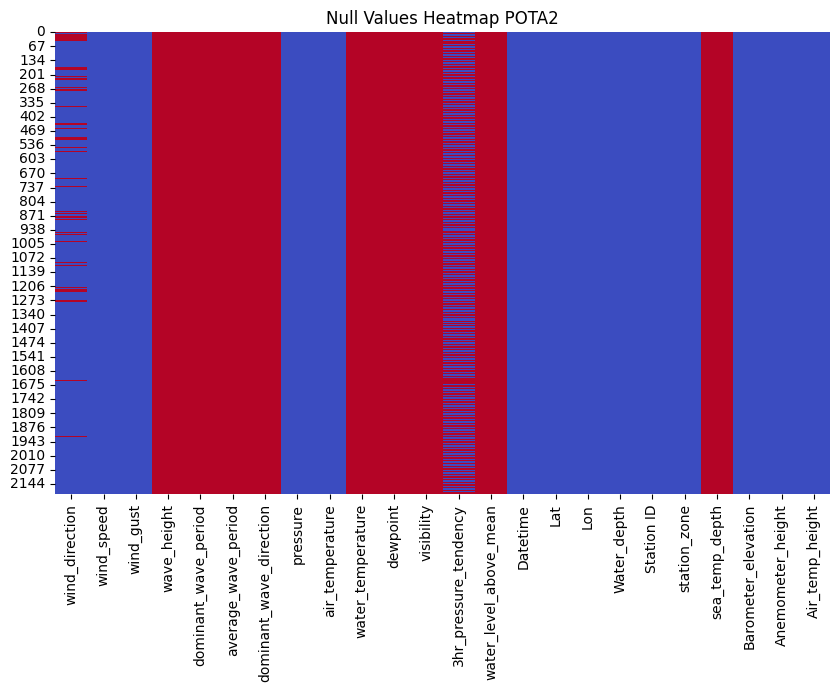

In [14]:
df_marine_random = random.choice(list_df_marine)


# Marine null values heatmap
plt.figure(figsize=(10, 6))

sns.heatmap(df_marine_random.isnull(), cbar=False, cmap='coolwarm')

plt.title(f'Null Values Heatmap {df_marine_random['Station ID'][0]}')

plt.show()

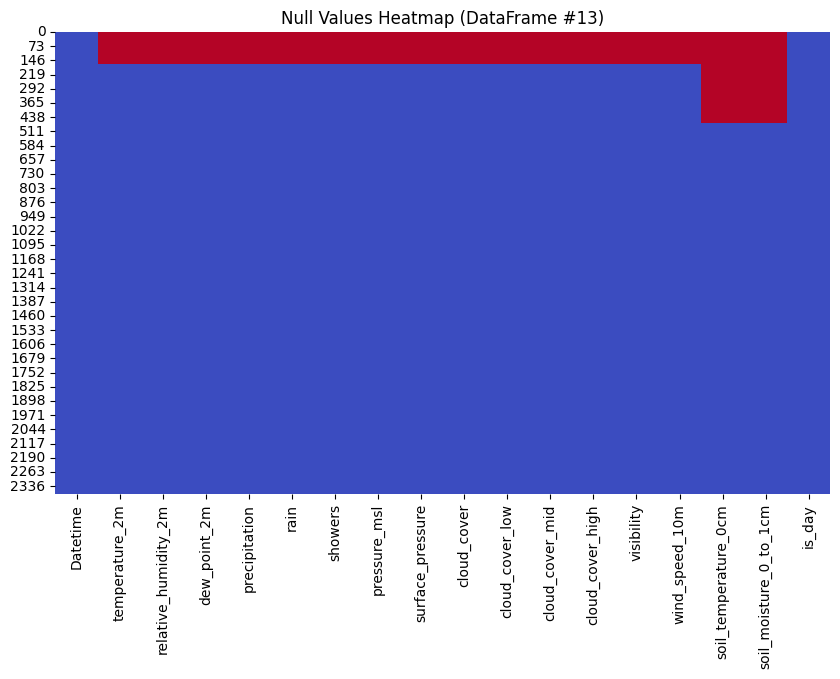

In [15]:
# S√©lectionner une DataFrame al√©atoire et r√©cup√©rer son index
random_index = random.randint(0, len(list_df_meteo) - 1)
df_meteo_random = list_df_meteo[random_index]

# Marine null values heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_meteo_random.isnull(), cbar=False, cmap='coolwarm')
plt.title(f'Null Values Heatmap (DataFrame #{random_index})')
plt.show()


In [16]:
important_columns_oceanography = [
    'wind_direction',             
    'wind_speed',                 
    'wave_height',                   
    'pressure',                   
    'air_temperature',            
    'water_temperature',          
    'Datetime',
    'Lat',
    'Lon'                 
]

important_columns_meteorology = [
    'temperature_2m',             
    'relative_humidity_2m',       
    'dew_point_2m',               
    'precipitation',              
    'pressure_msl',               
    'cloud_cover',                
    'wind_speed_10m',             
    'Datetime'
]

initial_meteo_data_count = 0
initial_marine_data_count = 0

marine_data_after_cleaning = 0
meteo_data_after_cleaning = 0

stations_depart = len(buoy_datas)
ignored_buoys = {}  # Dictionary to track ignored buoys and their reasons

for station_id, data in buoy_datas.items():
    print(f"\nüîÑ Nettoyage des donn√©es pour la station {station_id}")

    marine_df = data.get("Marine")
    meteo_df = data.get("Meteo")

    if marine_df is None or meteo_df is None:
        ignored_buoys[station_id] = "Marine DataFrame ou Meteo DataFrame manquant(e)"
        print(f"‚ö†Ô∏è Station {station_id} ignor√©e: Marine DataFrame ou Meteo DataFrame manquant(e)")
        continue

    initial_marine_data_count += marine_df.shape[0]
    initial_meteo_data_count += meteo_df.shape[0]

    try:
        # Nettoyage des DataFrames
        cleaned_marine_df = handle_null_values(marine_df)
        cleaned_meteo_df = handle_null_values(meteo_df)
        # V√©rification des colonnes importantes apr√®s nettoyage
        marine_columns_ok = all(col in cleaned_marine_df.columns for col in important_columns_oceanography)
        meteo_columns_ok = all(col in cleaned_meteo_df.columns for col in important_columns_meteorology)

        # Track which columns are missing
        missing_marine_columns = [col for col in important_columns_oceanography if col not in cleaned_marine_df.columns]
        missing_meteo_columns = [col for col in important_columns_meteorology if col not in cleaned_meteo_df.columns]

        if missing_marine_columns or missing_meteo_columns:
            ignored_buoys[station_id] = f"Colonnes manquantes: Marine: {missing_marine_columns}, Meteo: {missing_meteo_columns}"
            print(f"‚ö†Ô∏è Station {station_id} ignor√©e: Colonnes manquantes - Marine: {missing_marine_columns}, Meteo: {missing_meteo_columns}")
            continue

        # Ajouter le DataFrame nettoy√© au dictionnaire des r√©sultats
        buoy_datas[station_id]['Cleaned Marine'] = cleaned_marine_df
        buoy_datas[station_id]['Cleaned Meteo'] = cleaned_meteo_df
        print(f"‚úÖ Nettoyage r√©ussi pour la station {station_id} ({cleaned_marine_df.shape[0]} lignes)")

        marine_data_after_cleaning += cleaned_marine_df.shape[0]
        meteo_data_after_cleaning += cleaned_meteo_df.shape[0]
        

    except Exception as e:
        ignored_buoys[station_id] = f"Erreur lors du nettoyage: {e}"
        print(f"‚ùå Erreur lors du nettoyage pour {station_id}: {e}")

# üî• Suppression des stations ignor√©es du dictionnaire principal
for station_id in ignored_buoys:
    buoy_datas.pop(station_id, None)

len_cleaned_data = len([data for data in buoy_datas.values() if 'Cleaned Marine' in data and 'Cleaned Meteo' in data])

# R√©sum√© final du nettoyage
print("\nüìä R√âSUM√â DU NETTOYAGE:")
print(f"üìå Stations au d√©part : {stations_depart}")
print(f"‚úÖ Stations nettoy√©es : {len_cleaned_data}")
print(f"üèÅ Stations restantes apr√®s filtrage :")

for station_id, reason in ignored_buoys.items():
    print(f"üõë Station {station_id} ignor√©e: {reason}")

print(f"\nüßπ Cl√©s restantes dans buoy_datas apr√®s purge : {len(buoy_datas)} (attendu : {len_cleaned_data})")


print(f"\nüìä Nombre de donn√©es initiales : Marine: {initial_marine_data_count}, M√©t√©o: {initial_meteo_data_count}")
print(f"üìä Nombre de donn√©es apr√®s nettoyage : Marine: {marine_data_after_cleaning}, M√©t√©o: {meteo_data_after_cleaning}")


üîÑ Nettoyage des donn√©es pour la station 41004

Tag: orange - Nombre de lignes: 6497
Colonne 'wind_direction' Imput√©e par la m√©diane (0.38% de valeurs manquantes)
Colonne 'wind_speed' Imput√©e par la m√©diane (0.26% de valeurs manquantes)
Colonne 'wind_gust' Imput√©e par la m√©diane (0.26% de valeurs manquantes)
Colonne 'wave_height' Imput√©e par la m√©diane (46.62% de valeurs manquantes)
Colonne 'dominant_wave_period' Supprim√©e (plus de 55% de valeurs manquantes)
Colonne 'average_wave_period' Imput√©e par la m√©diane (46.62% de valeurs manquantes)
Colonne 'dominant_wave_direction' Imput√©e par la m√©diane (46.62% de valeurs manquantes)
Colonne 'pressure' Imput√©e par la m√©diane (0.22% de valeurs manquantes)
Colonne 'air_temperature' Imput√©e par la m√©diane (0.28% de valeurs manquantes)
Colonne 'water_temperature' Imput√©e par la m√©diane (1.72% de valeurs manquantes)
Colonne 'dewpoint' Imput√©e par la m√©diane (0.95% de valeurs manquantes)
Colonne 'visibility' Supprim√©e (plu

In [17]:
display_buoys_missing_df_counts(buoy_datas, prefix="Cleaned")


üåä Nombre de bou√©es sans donn√©es 'Cleaned Marine' : 0/25

‚òÅÔ∏è Nombre de bou√©es sans donn√©es 'Cleaned Meteo' : 0/25


In [18]:
display_row_values(df_meteo)

Index  |  Datetime             |  temperature_2m  |  relative_humidity_2m  |  dew_point_2m  |  precipitation  |  rain  |  showers  |  pressure_msl  |  surface_pressure  |  cloud_cover  |  cloud_cover_low  |  cloud_cover_mid  |  cloud_cover_high  |  visibility  |  wind_speed_10m  |  soil_temperature_0cm  |  soil_moisture_0_to_1cm  |  is_day
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0      |  2025-01-27 00:00:00  |  3.4850001       |  72.0                  |  -0.85         |  0.0            |  0.0   |  0.0      |  1016.0        |  991.185           |  78.5         |  9.0              |  0.0              |  0.0               |  24140.0     |  17.9            |  8.39                  |  0.3                     | 

Fusionner les df_meteo et df_marine sur 'Datetime'

In [19]:
# Fusion des DataFrames nettoy√©s
print("\nüîó FUSION DES DONN√âES MARINE + METEO PAR STATION")

merged_success_count = 0  # Compteur de fusions r√©ussies
total_merged_rows = 0     # Total de lignes fusionn√©es

for station_id, data in buoy_datas.items():
    print(f"\nüîÑ Fusion des donn√©es pour la station {station_id}")

    cleaned_marine_df = data.get("Cleaned Marine")
    cleaned_meteo_df = data.get("Cleaned Meteo")

    if cleaned_marine_df is None or cleaned_meteo_df is None:
        continue

    try:
        merged_df = pd.merge(cleaned_marine_df, cleaned_meteo_df, on="Datetime", how="inner")

        if merged_df.empty:
            print(f"‚ö†Ô∏è Station {station_id} fusionn√©e, mais r√©sultat vide apr√®s inner merge sur 'Datetime'")
        else:
            buoy_datas[station_id]["Merged"] = merged_df
            merged_success_count += 1
            total_merged_rows += len(merged_df)
            print(f"‚úÖ Fusion r√©ussie pour la station {station_id} ({merged_df.shape[0]} lignes)")

    except Exception as e:
        print(f"‚ùå Erreur lors de la fusion pour {station_id}: {e}")

# R√©sum√© des fusions
print(f"\nüì¶ Fusions r√©ussies : {merged_success_count}/{len_cleaned_data} stations")
print(f"üìä Total de lignes fusionn√©es : {total_merged_rows}")


üîó FUSION DES DONN√âES MARINE + METEO PAR STATION

üîÑ Fusion des donn√©es pour la station 41004
‚úÖ Fusion r√©ussie pour la station 41004 (1092 lignes)

üîÑ Fusion des donn√©es pour la station 41008
‚úÖ Fusion r√©ussie pour la station 41008 (1098 lignes)

üîÑ Fusion des donn√©es pour la station 41044
‚úÖ Fusion r√©ussie pour la station 41044 (1090 lignes)

üîÑ Fusion des donn√©es pour la station 41046
‚úÖ Fusion r√©ussie pour la station 41046 (186 lignes)

üîÑ Fusion des donn√©es pour la station 41049
‚úÖ Fusion r√©ussie pour la station 41049 (1098 lignes)

üîÑ Fusion des donn√©es pour la station 42001
‚úÖ Fusion r√©ussie pour la station 42001 (1097 lignes)

üîÑ Fusion des donn√©es pour la station 42002
‚úÖ Fusion r√©ussie pour la station 42002 (1095 lignes)

üîÑ Fusion des donn√©es pour la station 42020
‚úÖ Fusion r√©ussie pour la station 42020 (1098 lignes)

üîÑ Fusion des donn√©es pour la station 42036
‚úÖ Fusion r√©ussie pour la station 42036 (1097 lignes)

üîÑ Fusion

In [20]:
cleaned_marine_df.head()

wind_direction  wind_speed  wind_gust  wave_height  average_wave_period  \
0            90.0         7.0        8.0          2.0                  6.2   
1           100.0         7.0        8.0          2.0                  6.2   
2           100.0         7.0        9.0          2.0                  6.2   
3           100.0         7.0        9.0          2.0                  6.2   
4           100.0         7.0        9.0          2.0                  6.2   

   dominant_wave_direction  pressure  air_temperature  water_temperature  \
0                    101.0    1017.0             25.1               25.8   
1                    106.0    1017.0             25.1               25.8   
2                    106.0    1016.9             25.1               25.8   
3                    101.0    1016.7             25.0               25.8   
4                     97.0    1016.6             25.0               25.8   

   dewpoint            Datetime     Lat      Lon Water_depth Station ID  \
0      21.7 2025-04-29 18:30:00  17.07N  157.75W      4979 m      51002   
1      21.5 2025-04-29 18:20:00  17.07N  157.75W      4979 m      51002   
2      21.6 2025-04-29 18:10:00  17.07N  157.75W      4979 m      51002   
3      21.5 2025-04-29 18:00:00  17.07N  157.75W      4979 m      51002   
4      21.6 2025-04-29 17:50:00  17.07N  157.75W      4979 m      51002   

       station_zone sea_temp_depth Barometer_elevation Anemometer_height  \
0  southwest hawaii            1.5                 2.7               4.1   
1  southwest hawaii            1.5                 2.7               4.1   
2  southwest hawaii            1.5                 2.7               4.1   
3  southwest hawaii            1.5                 2.7               4.1   
4  southwest hawaii            1.5                 2.7               4.1   

  Air_temp_height  
0             3.7  
1             3.7  
2             3.7  
3             3.7  
4             3.7

Concat√©nation des DataFrames fusionn√©s

In [21]:
# Concat√©nation des DataFrames fusionn√©s
print("\nüß¨ CONCAT√âNATION DES DONN√âES FUSIONN√âES EN UN SEUL DATAFRAME")

final_merged_df_list = []
concat_success_count = 0
concat_total_rows = 0

for station_id, data in buoy_datas.items():
    merged_df = data.get("Merged")

    if merged_df is None:
        print(f"‚ö†Ô∏è Station {station_id} ignor√©e pour concat√©nation: Donn√©es fusionn√©es manquantes")
        continue

    try:
        final_merged_df_list.append(merged_df)
        concat_success_count += 1
        concat_total_rows += len(merged_df)
        print(f"‚úÖ Concat√©nation r√©ussie pour la station {station_id} ({len(merged_df)} lignes)")

    except Exception as e:
        print(f"‚ùå Erreur lors de la concat√©nation pour {station_id}: {e}")

# Cr√©ation du DataFrame final unique
try:
    df_final = pd.concat(final_merged_df_list, ignore_index=True)
    print(f"\nüßæ DataFrame final cr√©√© avec succ√®s ({df_final.shape[0]} lignes, {df_final.shape[1]} colonnes)")
except Exception as e:
    print(f"\n‚ùå Erreur lors de la cr√©ation du DataFrame final: {e}")
    df_final = None

# R√©sum√©
print(f"\nüì¶ Concat√©nations r√©ussies : {concat_success_count}/{merged_success_count}")
print(f"üìä Total de lignes dans le DataFrame final : {concat_total_rows}")


üß¨ CONCAT√âNATION DES DONN√âES FUSIONN√âES EN UN SEUL DATAFRAME
‚úÖ Concat√©nation r√©ussie pour la station 41004 (1092 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 41008 (1098 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 41044 (1090 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 41046 (186 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 41049 (1098 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 42001 (1097 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 42002 (1095 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 42020 (1098 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 42036 (1097 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 42056 (1098 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 42058 (1095 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 44007 (1097 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 44020 (1097 lignes)
‚úÖ Concat√©nation r√©ussie pour la station 44065 (1099 lignes)
‚úÖ Concat√©nation r√©ussie pour la st

In [22]:
display_row_values(df_final)

Index  |  wind_direction  |  wind_speed  |  wind_gust  |  wave_height  |  average_wave_period  |  dominant_wave_direction  |  pressure  |  air_temperature     |  water_temperature  |  dewpoint  |  Datetime             |  Lat     |  Lon      |  Water_depth  |  Station ID  |  station_zone                              |  sea_temp_depth  |  Barometer_elevation  |  Anemometer_height  |  Air_temp_height  |  temperature_2m  |  relative_humidity_2m  |  dew_point_2m  |  precipitation  |  rain  |  showers  |  pressure_msl  |  surface_pressure  |  cloud_cover  |  cloud_cover_low  |  cloud_cover_mid  |  cloud_cover_high  |  visibility  |  wind_speed_10m  |  soil_temperature_0cm  |  soil_moisture_0_to_1cm  |  is_day
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [23]:
df_final.index

RangeIndex(start=0, stop=26509, step=1)

In [24]:
df_final.dtypes

wind_direction                    float64
wind_speed                        float64
wind_gust                         float64
wave_height                       float64
average_wave_period               float64
dominant_wave_direction           float64
pressure                          float64
air_temperature                   float64
water_temperature                 float64
dewpoint                          float64
Datetime                   datetime64[ns]
Lat                                object
Lon                                object
Water_depth                        object
Station ID                         object
station_zone                       object
sea_temp_depth                     object
Barometer_elevation                object
Anemometer_height                  object
Air_temp_height                    object
temperature_2m                    float32
relative_humidity_2m              float32
dew_point_2m                      float32
precipitation                     

Null values heatmap

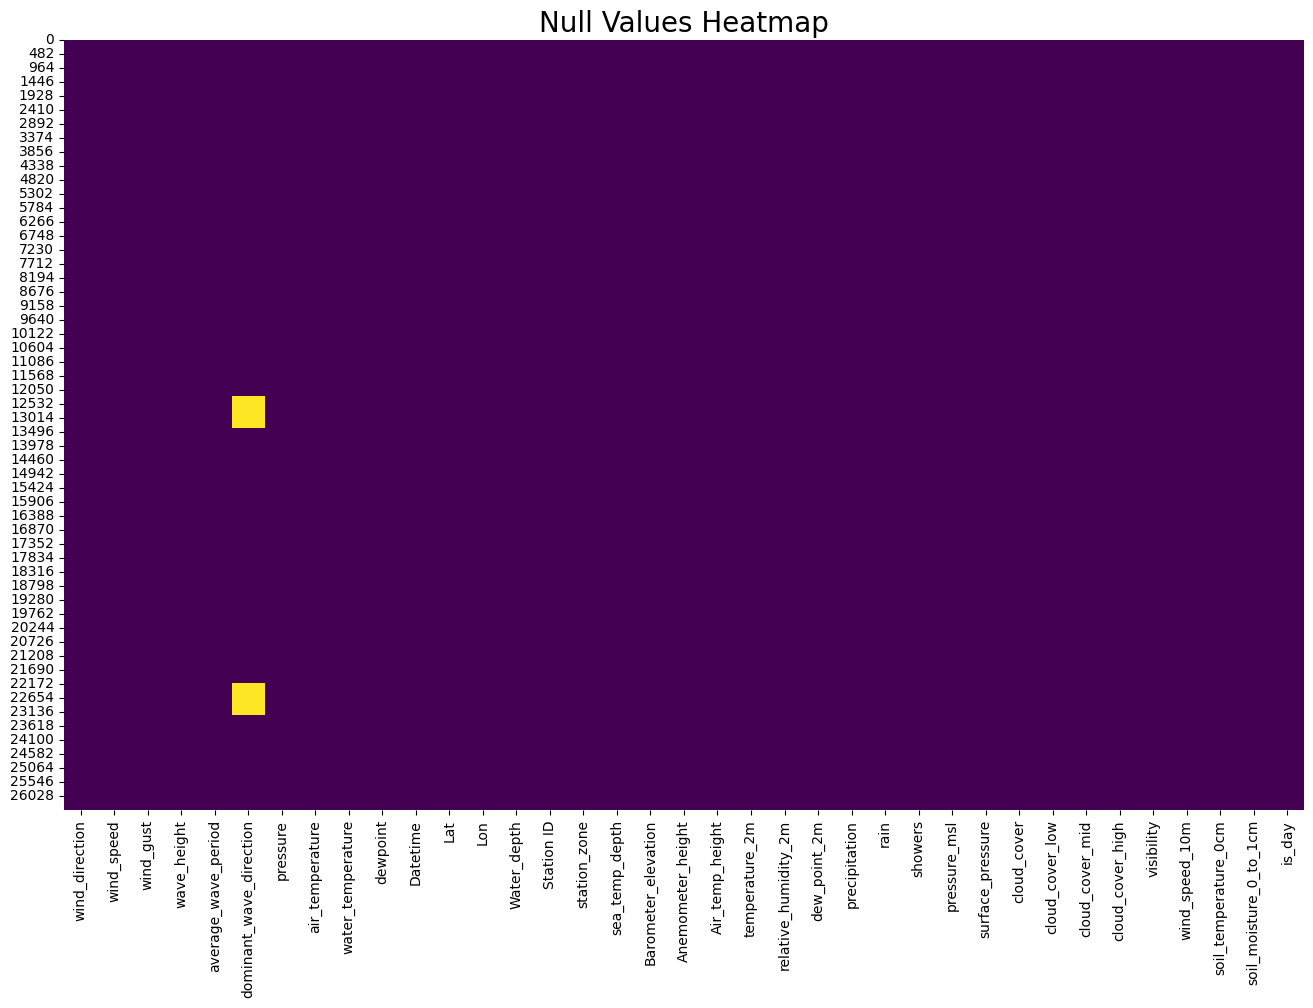

In [25]:
# null value heatmap with sns

plt.figure(figsize=(16, 10))

sns.heatmap(df_final.isnull(), cbar=False, cmap='viridis')

plt.title('Null Values Heatmap', fontdict={'size': 20})

plt.show()

In [26]:
df_final = handle_null_values(df_final)
display_row_values(df_final)


Tag: yellow - Nombre de lignes: 26509
Colonne 'wind_direction' non modifi√©e (0% de valeurs manquantes)
Colonne 'wind_speed' non modifi√©e (0% de valeurs manquantes)
Colonne 'wind_gust' non modifi√©e (0% de valeurs manquantes)
Colonne 'wave_height' non modifi√©e (0% de valeurs manquantes)
Colonne 'average_wave_period' non modifi√©e (0% de valeurs manquantes)
Colonne 'dominant_wave_direction' Imput√©e par la m√©diane (8.28% de valeurs manquantes)
Colonne 'pressure' non modifi√©e (0% de valeurs manquantes)
Colonne 'air_temperature' non modifi√©e (0% de valeurs manquantes)
Colonne 'water_temperature' non modifi√©e (0% de valeurs manquantes)
Colonne 'dewpoint' non modifi√©e (0% de valeurs manquantes)
Colonne 'Datetime' non modifi√©e (0% de valeurs manquantes)
Colonne 'Lat' non modifi√©e (0% de valeurs manquantes)
Colonne 'Lon' non modifi√©e (0% de valeurs manquantes)
Colonne 'Water_depth' non modifi√©e (0% de valeurs manquantes)
Colonne 'Station ID' non modifi√©e (0% de valeurs manquantes

Hour Filtering

In [27]:
try:
    df_final = df_final[['Datetime', 'Lat', 'Lon'] + [col for col in df_final.columns if col not in ['Datetime', 'Lat', 'Lon']]]
    # placer la colonne Datetime en %Y-%m-%d %H
    
    print(f"üöÄ DataFrame filtr√©e pour ne garder que les lignes √† l'heure pile: {df_final.shape[0]} lignes")

except Exception as e:
    print(str(e))
finally:
    display(df_final.columns)

üöÄ DataFrame filtr√©e pour ne garder que les lignes √† l'heure pile: 26509 lignes


Index(['Datetime', 'Lat', 'Lon', 'wind_direction', 'wind_speed', 'wind_gust',
       'wave_height', 'average_wave_period', 'dominant_wave_direction',
       'pressure', 'air_temperature', 'water_temperature', 'dewpoint',
       'Water_depth', 'Station ID', 'station_zone', 'sea_temp_depth',
       'Barometer_elevation', 'Anemometer_height', 'Air_temp_height',
       'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'precipitation', 'rain', 'showers', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'visibility', 'wind_speed_10m', 'soil_temperature_0cm',
       'soil_moisture_0_to_1cm', 'is_day'],
      dtype='object')

In [28]:
df_final.columns = [col.strip() for col in df_final.columns]

Renaming and deleting useless columns

In [29]:
# Dictionnaire de renommage des colonnes
col_to_rename = {'temperature_2m': 'T¬∞(C¬∞)', 
                 'relative_humidity_2m': 'Relative Humidity (%)',
                 'dew_point_2m': 'Dew Point (¬∞C)', 
                 'precipitation': 'Precipitations (mm)',  
                 'pressure_msl':'Sea Level Pressure (hPa)', 
                 'cloud_cover_low':'Low Clouds (%)',
                 'cloud_cover_mid' : 'Middle Clouds (%)', 
                 'cloud_cover_high' : 'High Clouds (%)', 
                 'visibility' : 'Visibility (km)', 
                 'wind_direction': 'Wind Direction (¬∞)',
                 'wind_speed': 'Wind Speed (km/h)', 
                 'wind_gust': 'Wind Gusts (km/h)',
                 'wind_speed_10m':'Wind Speed (10m)', 
                 'surface_pressure': 'Surface Pressure',
                 'wave_height': 'Wave Height (m)', 
                 'average_wave_period': 'Average Wave Period (s)',
                 'dominant_wave_direction': 'Dominant Wave Direction (¬∞)', 
                 'pressure': 'Pressure (hPa)',
                 'air_temperature': 'Air T¬∞', 
                 'water_temperature': 'Water T¬∞', 
                 'Water_depth': 'Water Depth (m)', 
                 "Air_temp_height": "Air T¬∞ Height", 
                 "Anemometer_height": "Anemometer Height (m)", 
                 "station_zone": "Station Zone",
                 "Barometer_elevation": "Barometer Elevation", 
                 "sea_temp_depth" : "Sea Temperature Depth (m)",
                 "cloud_cover": "Cloud Cover (%)"
                 }

# Liste des colonnes √† supprimer
cols_to_delete = ['soil_temperature_0cm', 'lat_buoy','lon_buoy', 'rain', 
                  'showers', 'is_day', 'soil_moisture_0_to_1cm']
	
# Renommer les colonnes d'abord
df_final = rename_columns(df_final, col_to_rename)
# Ensuite, supprimer les colonnes non d√©sir√©es
df_final = drop_columns_if_exist(df_final, cols_to_delete)
try:
    if df_final['Visibility (km)'].mean() > 1000:
        df_final['Visibility (km)'] = df_final['Visibility (km)'] / 1000
        print("Conversion de la visibilit√© de m√®tres √† kilom√®tres")
    df_final["T¬∞(C¬∞)"] = round(df_final["T¬∞(C¬∞)"], 2)
    df_final["Wind Speed (10m)"] = round(df_final["Wind Speed (10m)"], 2)
except Exception as e:
    print(f"ÔøΩÔøΩ Erreur lors du traitement des colonnes :\n {e}")

# Afficher les r√©sultats
print("\nColonnes apr√®s renommage et suppression :")
print("\n")
display_row_values(df_final)

üîÑ Colonne 'temperature_2m' renomm√©e en 'T¬∞(C¬∞)'
üîÑ Colonne 'relative_humidity_2m' renomm√©e en 'Relative Humidity (%)'
üîÑ Colonne 'dew_point_2m' renomm√©e en 'Dew Point (¬∞C)'
üîÑ Colonne 'precipitation' renomm√©e en 'Precipitations (mm)'
üîÑ Colonne 'pressure_msl' renomm√©e en 'Sea Level Pressure (hPa)'
üîÑ Colonne 'cloud_cover_low' renomm√©e en 'Low Clouds (%)'
üîÑ Colonne 'cloud_cover_mid' renomm√©e en 'Middle Clouds (%)'
üîÑ Colonne 'cloud_cover_high' renomm√©e en 'High Clouds (%)'
üîÑ Colonne 'visibility' renomm√©e en 'Visibility (km)'
üîÑ Colonne 'wind_direction' renomm√©e en 'Wind Direction (¬∞)'
üîÑ Colonne 'wind_speed' renomm√©e en 'Wind Speed (km/h)'
üîÑ Colonne 'wind_gust' renomm√©e en 'Wind Gusts (km/h)'
üîÑ Colonne 'wind_speed_10m' renomm√©e en 'Wind Speed (10m)'
üîÑ Colonne 'surface_pressure' renomm√©e en 'Surface Pressure'
üîÑ Colonne 'wave_height' renomm√©e en 'Wave Height (m)'
üîÑ Colonne 'average_wave_period' renomm√©e en 'Average Wave Period (s

Transformer les coordonn√©es en format float

In [30]:
try:

    df_final[['Lat', 'Lon']] = df_final.apply(
        lambda row: pd.Series(convert_coordinates(row['Lat'], row['Lon'])),
        axis=1
    )
except Exception as e:
    print(f"Erreur : {e}")
finally:
    display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Speed (km/h)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Pressure (hPa)  |  Air T¬∞              |  Water T¬∞  |  dewpoint  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation  |  Anemometer Height (m)  |  Air T¬∞ Height  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Surface Pressure  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Pressure and air temperatures are very close
We'll make the average of them all

In [31]:
try:
    df_final['T¬∞(C¬∞)'] = (df_final['Air T¬∞'] + df_final['T¬∞(C¬∞)']) / 2
    df_final['T¬∞(C¬∞)'] = df_final['T¬∞(C¬∞)'].round(2)
    df_final.drop(columns=['Air T¬∞'], inplace=True)
    
    df_final['Sea Level Pressure (hPa)'] = round((df_final['Sea Level Pressure (hPa)'] + df_final['Surface Pressure']) / 2, 2)
    df_final.drop(columns=['Surface Pressure'], inplace=True)
except Exception as e:
    print(f"Erreur :\n {e}")
    
display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Speed (km/h)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Pressure (hPa)  |  Water T¬∞  |  dewpoint  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation  |  Anemometer Height (m)  |  Air T¬∞ Height  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Create Categorical Time columns and delete the 'm' in Water Depth Column

In [32]:
try:
    # Cr√©er une colonne temporaire pour acc√©der √† .dt

    df_final['Year'] = df_final['Datetime'].dt.year.astype(str)
    df_final['Month'] = df_final['Datetime'].dt.month_name()
    df_final['Day'] = df_final['Datetime'].dt.day.astype(str)
    df_final['Hour'] = df_final['Datetime'].dt.hour.astype(str)
    df_final['DayOfWeek'] = df_final['Datetime'].dt.day_name()
    df_final['DayPeriod'] = df_final['Datetime'].apply(
        lambda x: 'Morning' if 6 <= x.hour < 12 else
                  'Afternoon' if 12 <= x.hour < 18 else
                  'Evening' if 18 <= x.hour < 22 else
                  'Night'
    )

except Exception as e:
    print(f"Erreur :\n {e}")

try:
    # virer le m dans Water Depth avec regex lambda et passer la colonne en float
    df_final['Water Depth (m)'] = df_final['Water Depth (m)'].apply(lambda x: re.sub(r'\D', '', str(x)).strip())
    df_final['Water Depth (m)'] = df_final['Water Depth (m)'].astype(float)
except Exception as e:
    print(str(e))

display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Speed (km/h)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Pressure (hPa)  |  Water T¬∞  |  dewpoint  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation  |  Anemometer Height (m)  |  Air T¬∞ Height  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  Day  |  Hour  |  DayOfWeek  |  DayPeriod
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [33]:
df_final.dtypes

Datetime                       datetime64[ns]
Lat                                   float64
Lon                                   float64
Wind Direction (¬∞)                    float64
Wind Speed (km/h)                     float64
Wind Gusts (km/h)                     float64
Wave Height (m)                       float64
Average Wave Period (s)               float64
Dominant Wave Direction (¬∞)           float64
Pressure (hPa)                        float64
Water T¬∞                              float64
dewpoint                              float64
Water Depth (m)                       float64
Station ID                             object
Station Zone                           object
Sea Temperature Depth (m)              object
Barometer Elevation                    object
Anemometer Height (m)                  object
Air T¬∞ Height                          object
T¬∞(C¬∞)                                float64
Relative Humidity (%)                 float32
Dew Point (¬∞C)             

Check truth about Wind Speed Using another API call

In [34]:
df_42058 = df_final[df_final['Station ID'] == "42058"]
df_42058.columns

Index(['Datetime', 'Lat', 'Lon', 'Wind Direction (¬∞)', 'Wind Speed (km/h)',
       'Wind Gusts (km/h)', 'Wave Height (m)', 'Average Wave Period (s)',
       'Dominant Wave Direction (¬∞)', 'Pressure (hPa)', 'Water T¬∞', 'dewpoint',
       'Water Depth (m)', 'Station ID', 'Station Zone',
       'Sea Temperature Depth (m)', 'Barometer Elevation',
       'Anemometer Height (m)', 'Air T¬∞ Height', 'T¬∞(C¬∞)',
       'Relative Humidity (%)', 'Dew Point (¬∞C)', 'Precipitations (mm)',
       'Sea Level Pressure (hPa)', 'Cloud Cover (%)', 'Low Clouds (%)',
       'Middle Clouds (%)', 'High Clouds (%)', 'Visibility (km)',
       'Wind Speed (10m)', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
       'DayPeriod'],
      dtype='object')

Requ√™te √† l'API Visual Crossing pour les donn√©es de v√©rification (1 / 24h)

In [35]:
# ---- Chargement de la cl√© API ----
vc_api_key_path = r"c:\Credentials\visual_crossing_weather_api.json"
with open(vc_api_key_path, 'r') as file:
    content = json.load(file)
    vc_api_key = content["api_key"]

# ---- Extraire les coordonn√©es depuis la premi√®re ligne du DataFrame ----
lat_42058, lon_42058 = None, None

if not df_42058.empty:
    first_row = df_42058.iloc[0]
    lat_42058, lon_42058 = first_row["Lat"], first_row["Lon"]

# ---- D√©finir les dates pour la requ√™te ----
today = datetime.now().strftime("%Y-%m-%d")
last_month = (datetime.now() - timedelta(days=31)).strftime("%Y-%m-%d")

# ---- Cr√©er le dossier de cache si n√©cessaire ----
cache_dir = "api_call_files"
os.makedirs(cache_dir, exist_ok=True)

# ---- D√©finir le fichier cache selon la position ----
cache_file = os.path.join(cache_dir, f"vc_meteo_{lat_42058}_{lon_42058}.csv")

# ---- V√©rifier si un cache r√©cent existe (moins de 24h) ----
use_cache = False
if os.path.exists(cache_file):
    last_modified = datetime.fromtimestamp(os.path.getmtime(cache_file))
    if datetime.now() - last_modified < timedelta(hours=24):
        print(f"üì¶ Cache d√©tect√© ({cache_file}), modifi√© le {last_modified.strftime('%Y-%m-%d %H:%M:%S')}")
        vc_meteo_df = pd.read_csv(cache_file)
        print("‚úÖ Donn√©es m√©t√©o recharg√©es depuis le cache.")
        use_cache = True
    else:
        print(f"‚ö†Ô∏è Cache trouv√© mais p√©rim√© (plus de 24h) ‚Üí nouvelle requ√™te API.")

# ---- Appel API si pas de cache valide ----
if not use_cache and lat_42058 is not None and lon_42058 is not None:
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{lat_42058},{lon_42058}/{last_month}/{today}?unitGroup=metric&key={vc_api_key}&contentType=json"
    
    try:
        response = requests.get(url)
        if response.status_code == 200:
            vc_meteo_data = response.json()
            print("üåç Donn√©es m√©t√©o r√©cup√©r√©es depuis l'API Visual Crossing.")

            # ---- Extraire les donn√©es journali√®res et sauvegarder ----
            if "days" in vc_meteo_data:
                vc_meteo_df = pd.json_normalize(vc_meteo_data["days"])
                vc_meteo_df.to_csv(cache_file, index=False)
                print(f"üíæ Donn√©es sauvegard√©es dans le cache : {cache_file}")
            else:
                print("‚ö†Ô∏è Le champ 'days' est absent de la r√©ponse API.")
        else:
            print(f"‚ùå √âchec de l‚Äôappel API ‚Äî code de statut : {response.status_code}")
    except Exception as e:
        print(f"‚ùå Exception lev√©e lors de la requ√™te API : {e}")
        

# üìÅ Charger les donn√©es du CSV Visual Crossing
vc_csv_path = f"vc_api_call_files/vc_meteo_{lat_42058}_{lon_42058}.csv"
df_vc_meteo = pd.read_csv(vc_csv_path)
try:
    # mettre Datetime en index
    df_vc_meteo.rename(columns={"datetime": "Datetime"}, inplace=True)  
    
except Exception as e:
    print(f"Erreur :\n {e}")

df_vc_meteo.head()

‚ùå √âchec de l‚Äôappel API ‚Äî code de statut : 429


Datetime  datetimeEpoch  tempmax  tempmin  temp  feelslikemax  \
0  2025-03-29     1743224400     27.7     27.1  27.4          31.1   
1  2025-03-30     1743310800     27.9     26.9  27.4          31.2   
2  2025-03-31     1743397200     27.8     25.9  27.3          31.1   
3  2025-04-01     1743483600     27.7     27.3  27.4          31.2   
4  2025-04-02     1743570000     27.9     26.7  27.6          31.7   

   feelslikemin  feelslike   dew  humidity  ...  sunriseEpoch    sunset  \
0          29.7       30.6  23.7      80.2  ...    1743245886  18:12:37   
1          29.4       30.4  23.3      78.5  ...    1743332244  18:12:43   
2          25.9       30.2  23.4      79.4  ...    1743418602  18:12:50   
3          30.1       30.5  23.5      79.0  ...    1743504960  18:12:56   
4          26.7       30.7  23.7      79.4  ...    1743591318  18:13:03   

   sunsetEpoch moonphase              conditions  \
0   1743289957      0.00  Rain, Partially cloudy   
1   1743376363      0.04                    Rain   
2   1743462770      0.08  Rain, Partially cloudy   
3   1743549176      0.11        Partially cloudy   
4   1743635583      0.15  Rain, Partially cloudy   

                                         description               icon  \
0  Partly cloudy throughout the day with early mo...               rain   
1  Clear conditions throughout the day with rain ...               rain   
2  Partly cloudy throughout the day with a chance...               rain   
3                  Partly cloudy throughout the day.  partly-cloudy-day   
4  Becoming cloudy in the afternoon with rain cle...               rain   

                       stations  source  \
0  ['42058_maritime', 'remote']     obs   
1  ['42058_maritime', 'remote']     obs   
2  ['42058_maritime', 'remote']     obs   
3            ['42058_maritime']     obs   
4  ['42058_maritime', 'remote']     obs   

                                               hours  
0  [{'datetime': '00:00:00', 'datetimeEpoch': 174...  
1  [{'datetime': '00:00:00', 'datetimeEpoch': 174...  
2  [{'datetime': '00:00:00', 'datetimeEpoch': 174...  
3  [{'datetime': '00:00:00', 'datetimeEpoch': 174...  
4  [{'datetime': '00:00:00', 'datetimeEpoch': 174...  

[5 rows x 37 columns]

# Nettoyage du DataFrame retourn√©

In [36]:
# üßº Nettoyage et transformation
all_hours = []

for i, row in df_vc_meteo.iterrows():
    try:
        hours_list = ast.literal_eval(row['hours'])

        for hour_data in hours_list:
            hour_data['Date'] = i  # ‚úÖ On met l'index courant, i.e. la date du jour
            all_hours.append(hour_data)

    except Exception as e:
        print(f"Erreur parsing ligne {i}: {e}")

df_vc_flat = pd.DataFrame(all_hours)

# üïí Convertir le timestamp en datetime string
df_vc_flat["Datetime"] = pd.to_datetime(df_vc_flat["datetimeEpoch"], unit="s").dt.strftime("%Y-%m-%d-%H")

# üóìÔ∏è Filtrer sur les 30 derniers jours
today = datetime.now()
thirty_days_ago = today - timedelta(days=30)

df_vc_flat['Date'] = pd.to_datetime(df_vc_flat['Date'])  # üëà Assurer que c'est bien du datetime
df_vc_last_month = df_vc_flat[
    (df_vc_flat['Date'] >= thirty_days_ago) & 
    (df_vc_flat['Date'] <= today)
]


# Renommage des colonnes pour faciliter la comparaison

In [37]:
#Filtrer les colonnes n√©cessaires
try:
    df_vc_last_month = df_vc_last_month[["Datetime", "temp", "humidity", "precip", "dew", "windgust", 
                                     "windspeed", "winddir", "pressure", "visibility"]]
except Exception as e:
        print(f"Erreur lors du filtrage des colonnes:\n {e}\n")

try:
        df_vc_last_month["Datetime"] = pd.to_datetime(df_vc_last_month["Datetime"], errors='coerce')
except Exception as e:
        print(f"Erreur lors du reformatage de la colonne Datetime:\n {e}\n")        

for col in df_vc_last_month.columns:
        try:
            # 
            if not "Datetime" in col:
                if not col.startswith("VC_"):
                        rename_columns(df_vc_last_month, {col: f"VC_{col}"})
        except Exception as e:
                print(f"Erreur lors du renommage de la colonne {col}:\n {e}\n")


üîÑ Colonne 'temp' renomm√©e en 'VC_temp'
‚úÖ Colonnes renomm√©es : {'temp': 'VC_temp'}
üîÑ Colonne 'humidity' renomm√©e en 'VC_humidity'
‚úÖ Colonnes renomm√©es : {'humidity': 'VC_humidity'}
üîÑ Colonne 'precip' renomm√©e en 'VC_precip'
‚úÖ Colonnes renomm√©es : {'precip': 'VC_precip'}
üîÑ Colonne 'dew' renomm√©e en 'VC_dew'
‚úÖ Colonnes renomm√©es : {'dew': 'VC_dew'}
üîÑ Colonne 'windgust' renomm√©e en 'VC_windgust'
‚úÖ Colonnes renomm√©es : {'windgust': 'VC_windgust'}
üîÑ Colonne 'windspeed' renomm√©e en 'VC_windspeed'
‚úÖ Colonnes renomm√©es : {'windspeed': 'VC_windspeed'}
üîÑ Colonne 'winddir' renomm√©e en 'VC_winddir'
‚úÖ Colonnes renomm√©es : {'winddir': 'VC_winddir'}
üîÑ Colonne 'pressure' renomm√©e en 'VC_pressure'
‚úÖ Colonnes renomm√©es : {'pressure': 'VC_pressure'}
üîÑ Colonne 'visibility' renomm√©e en 'VC_visibility'
‚úÖ Colonnes renomm√©es : {'visibility': 'VC_visibility'}


Enforce Datetime Format

In [38]:
# Check if the Datetime column is correctly converted
print(df_42058["Datetime"].dtype)
print(df_vc_last_month["Datetime"].dtype)

datetime64[ns]
datetime64[ns]


Merge and Compare DataFrames

In [39]:
try:
    
    df_compare = pd.merge(df_42058, df_vc_last_month, on="Datetime", how="inner")
    display(df_compare.columns)
    
except Exception as e:
    print(e)

Index(['Datetime', 'Lat', 'Lon', 'Wind Direction (¬∞)', 'Wind Speed (km/h)',
       'Wind Gusts (km/h)', 'Wave Height (m)', 'Average Wave Period (s)',
       'Dominant Wave Direction (¬∞)', 'Pressure (hPa)', 'Water T¬∞', 'dewpoint',
       'Water Depth (m)', 'Station ID', 'Station Zone',
       'Sea Temperature Depth (m)', 'Barometer Elevation',
       'Anemometer Height (m)', 'Air T¬∞ Height', 'T¬∞(C¬∞)',
       'Relative Humidity (%)', 'Dew Point (¬∞C)', 'Precipitations (mm)',
       'Sea Level Pressure (hPa)', 'Cloud Cover (%)', 'Low Clouds (%)',
       'Middle Clouds (%)', 'High Clouds (%)', 'Visibility (km)',
       'Wind Speed (10m)', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
       'DayPeriod', 'VC_temp', 'VC_humidity', 'VC_precip', 'VC_dew',
       'VC_windgust', 'VC_windspeed', 'VC_winddir', 'VC_pressure',
       'VC_visibility'],
      dtype='object')

Comparaison Wind Speed

In [40]:
try:
    # Wind Speed Comparison
    df_windspeed_compare = df_compare[['Wind Speed (km/h)', 'Wind Speed (10m)','VC_windspeed']]
    #  Pressure Comparison
    df_pressure_compare = df_compare[['Sea Level Pressure (hPa)','Pressure (hPa)', 'VC_pressure']]
    # Dew Point Comparison
    df_dew_compare = df_compare[['dewpoint','Dew Point (¬∞C)', 'VC_dew']]
except Exception as e:
    print(e)

df_windspeed_compare.head()

Empty DataFrame
Columns: [Wind Speed (km/h), Wind Speed (10m), VC_windspeed]
Index: []

In [41]:
wind_col_to_delete = ['Wind Speed (km/h)', 'Anemometer Height (m)']
df_final = drop_columns_if_exist(df_final, wind_col_to_delete)
# Arrondir les valeurs de df_final

df_final = df_final.round(2)

 Nombre initial de colonnes: 36
Colonne 'Wind Speed (km/h)' Supprim√©e
Colonne 'Anemometer Height (m)' Supprim√©e
 Nombre final de colonnes: 34


Comparaison Pressure

In [42]:
df_pressure_compare.head()

Empty DataFrame
Columns: [Sea Level Pressure (hPa), Pressure (hPa), VC_pressure]
Index: []

In [43]:
df_final = drop_columns_if_exist(df_final, ['Pressure (hPa)'])

 Nombre initial de colonnes: 34
Colonne 'Pressure (hPa)' Supprim√©e
 Nombre final de colonnes: 33


In [44]:
df_dew_compare.head()

Empty DataFrame
Columns: [dewpoint, Dew Point (¬∞C), VC_dew]
Index: []

In [45]:
try:
    df_final['Dew Point (¬∞C)'] = df_final['dewpoint']
    df_final = drop_columns_if_exist(df_final, ['dewpoint'])
    
except Exception as e:
    print(e)
display_row_values(df_final)

 Nombre initial de colonnes: 33
Colonne 'dewpoint' Supprim√©e
 Nombre final de colonnes: 32
Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Water T¬∞  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation  |  Air T¬∞ Height  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  Day  |  Hour  |  DayOfWeek  |  DayPeriod
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Rename Final Columns

In [46]:
try:
    df_final.rename(columns={'Air T¬∞ Height': 'Air T¬∞ Height (m)',
                             'Barometer Elevation': 'Barometer Elevation (m)',
                             'Water T¬∞': 'Water T¬∞ (¬∞C)'}, inplace=True)

    print("Column 'Air T¬∞ Height' renamed to 'Air T¬∞ Height (m)'")

    print("Column 'Barometer Elevation' renamed to 'Barometer Elevation (m)'")
    print("Column 'Water T¬∞' renamed to 'Water T¬∞ (¬∞C)'")
    df_final['T¬∞(C¬∞)'] = df_final['T¬∞(C¬∞)'].round(2)

    print("Column 'T¬∞(C¬∞)' rounded to 2 decimal places")
except Exception as e:
    print(e)
    
display_row_values(df_final)

Column 'Air T¬∞ Height' renamed to 'Air T¬∞ Height (m)'
Column 'Barometer Elevation' renamed to 'Barometer Elevation (m)'
Column 'Water T¬∞' renamed to 'Water T¬∞ (¬∞C)'
Column 'T¬∞(C¬∞)' rounded to 2 decimal places
Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Water T¬∞ (¬∞C)  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T¬∞ Height (m)  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  Day  |  Hour  |  DayOfWeek  |  DayPeriod
------------------------------------------------------------------------------------------------------------------------------

In [47]:
df_final.dtypes

Datetime                       datetime64[ns]
Lat                                   float64
Lon                                   float64
Wind Direction (¬∞)                    float64
Wind Gusts (km/h)                     float64
Wave Height (m)                       float64
Average Wave Period (s)               float64
Dominant Wave Direction (¬∞)           float64
Water T¬∞ (¬∞C)                         float64
Water Depth (m)                       float64
Station ID                             object
Station Zone                           object
Sea Temperature Depth (m)              object
Barometer Elevation (m)                object
Air T¬∞ Height (m)                      object
T¬∞(C¬∞)                                float64
Relative Humidity (%)                 float32
Dew Point (¬∞C)                        float64
Precipitations (mm)                   float32
Sea Level Pressure (hPa)              float32
Cloud Cover (%)                       float32
Low Clouds (%)            

In [48]:
# Correction des types des colonnes
try:
    df_final['Lat'] = df_final['Lat'].astype(str)
    df_final['Lon'] = df_final['Lon'].astype(str)
    print(df_final.dtypes)
except Exception as e:
    print(e)

Datetime                       datetime64[ns]
Lat                                    object
Lon                                    object
Wind Direction (¬∞)                    float64
Wind Gusts (km/h)                     float64
Wave Height (m)                       float64
Average Wave Period (s)               float64
Dominant Wave Direction (¬∞)           float64
Water T¬∞ (¬∞C)                         float64
Water Depth (m)                       float64
Station ID                             object
Station Zone                           object
Sea Temperature Depth (m)              object
Barometer Elevation (m)                object
Air T¬∞ Height (m)                      object
T¬∞(C¬∞)                                float64
Relative Humidity (%)                 float32
Dew Point (¬∞C)                        float64
Precipitations (mm)                   float32
Sea Level Pressure (hPa)              float32
Cloud Cover (%)                       float32
Low Clouds (%)            

In [49]:
display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Water T¬∞ (¬∞C)  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T¬∞ Height (m)  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  Day  |  Hour  |  DayOfWeek  |  DayPeriod
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [50]:
df_final.columns

Index(['Datetime', 'Lat', 'Lon', 'Wind Direction (¬∞)', 'Wind Gusts (km/h)',
       'Wave Height (m)', 'Average Wave Period (s)',
       'Dominant Wave Direction (¬∞)', 'Water T¬∞ (¬∞C)', 'Water Depth (m)',
       'Station ID', 'Station Zone', 'Sea Temperature Depth (m)',
       'Barometer Elevation (m)', 'Air T¬∞ Height (m)', 'T¬∞(C¬∞)',
       'Relative Humidity (%)', 'Dew Point (¬∞C)', 'Precipitations (mm)',
       'Sea Level Pressure (hPa)', 'Cloud Cover (%)', 'Low Clouds (%)',
       'Middle Clouds (%)', 'High Clouds (%)', 'Visibility (km)',
       'Wind Speed (10m)', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
       'DayPeriod'],
      dtype='object')

In [51]:
df_marine_cleaned = df_final[['Datetime', 'Lat', 'Lon',
       'Wave Height (m)', 'Average Wave Period (s)',
       'Dominant Wave Direction (¬∞)', 'Water T¬∞ (¬∞C)', 'Water Depth (m)',
       'Station ID', 'Station Zone', 'Sea Temperature Depth (m)',
       'Barometer Elevation (m)', 
       'Sea Level Pressure (hPa)', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
       'DayPeriod']]
df_meteo_cleaned = df_final[['Datetime', 'Lat', 'Lon', 
                             'Wind Direction (¬∞)', 'Wind Gusts (km/h)',
       'Station ID', 'Station Zone', 'Sea Temperature Depth (m)',
       'Barometer Elevation (m)', 'Air T¬∞ Height (m)', 'T¬∞(C¬∞)',

       'Relative Humidity (%)', 'Dew Point (¬∞C)', 'Precipitations (mm)',
       'Cloud Cover (%)', 'Low Clouds (%)',
       'Middle Clouds (%)', 'High Clouds (%)', 'Visibility (km)',
       'Wind Speed (10m)', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
       'DayPeriod']]

print(f"DataFrame Marine Index: {df_marine_cleaned.index}")
print(f"DataFrame Meteo Index: {df_meteo_cleaned.index}")

DataFrame Marine Index: RangeIndex(start=0, stop=26509, step=1)
DataFrame Meteo Index: RangeIndex(start=0, stop=26509, step=1)


In [52]:
marine_table_name = f"cleaned_marine_data"
create_table_in_mysql(table_name=table_staging_marine_name, 
                      engine=engine_staging, 
            df=df_marine_cleaned)

insert_new_rows(table_name=table_staging_marine_name, 
                engine=engine_staging, 
        df=df_marine_cleaned, ref= 'Datetime')



meteo_table_name = f"cleaned_meteo_data"
create_table_in_mysql(table_name= table_staging_meteo_name, 
        engine=engine_staging, df=df_meteo_cleaned)

insert_new_rows(table_name=table_staging_meteo_name, 
                engine=engine_staging, 
                df=df_meteo_cleaned, ref= 'Datetime')


üîÑ V√©rification de l'existence de la table...
‚ö†Ô∏è La table 'cleaned_marine_data' existe d√©j√†.
üîé 0 valeurs d√©j√† pr√©sentes dans la colonne 'Datetime'.
üöÄ Insertion de 26509 lignes dans 'cleaned_marine_data'...
‚úÖ Insertion termin√©e avec succ√®s.
üîÑ V√©rification de l'existence de la table...
‚ö†Ô∏è La table 'cleaned_meteo_data' existe d√©j√†.
üîé 1099 valeurs d√©j√† pr√©sentes dans la colonne 'Datetime'.
‚ö†Ô∏è Aucune nouvelle ligne √† ins√©rer.


In [53]:
csv_folder = 'csv'
base_filename = "Cleaned_Data_Ocean_Meteo_ETL"

# V√©rifier dans le dossier si de tels fichiers existent d√©j√† avec ce nom de base
existing_files = os.listdir(csv_folder)

# Filtrer ceux qui commencent par le nom de base et ont l'extension .csv
matching_files = [f for f in existing_files if f.startswith(base_filename) and f.endswith('.csv')]

if len(matching_files) > 0:
    # Cr√©er une liste vide pour stocker les DataFrames
    dfs = []

    # Lire chaque fichier CSV et ajouter la DataFrame √† la liste
    for file in matching_files:
        file_path = os.path.join(csv_folder, file)
        df = pd.read_csv(file_path)
        dfs.append(df)

    # Concat√©ner toutes les DataFrames en une seule
    df_concat_existing_files = pd.concat(dfs, ignore_index=True)
    
    # Concat√©ner les donn√©es existantes avec df_final
    concatenated_df = pd.concat([df_concat_existing_files, df_final], ignore_index=True)
    
    # Supprimer les doublons bas√©s sur la colonne 'Datetime'
    concatenated_df = concatenated_df.drop_duplicates(subset='Datetime', keep='last')
    concatenated_df['Datetime'] = pd.to_datetime(concatenated_df['Datetime'], errors='coerce')

    # Sauvegarder le CSV concat√©n√© sans doublons
    save_concat_csv(concatenated_df, csv_folder=csv_folder, base_filename="Cleaned_Data_Ocean_Meteo_ETL")
    
    # Supprimer les fichiers CSV d'ingr√©dients
    for file in matching_files:
        os.remove(os.path.join(csv_folder, file))
else:
    # Si aucun fichier existant, juste sauvegarder df_final
    save_concat_csv(df_final, csv_folder=csv_folder, base_filename="Cleaned_Data_Ocean_Meteo_ETL")


In [54]:
display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Water T¬∞ (¬∞C)  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T¬∞ Height (m)  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  Day  |  Hour  |  DayOfWeek  |  DayPeriod
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Cr√©ation des DataFrames pour les tables du DW

In [55]:
# Colonnes d√©riv√©es
df_finalfor_DW = df_final.copy()
df_finalfor_DW['Date ID'] = df_final['Datetime'].dt.strftime('%Y%m%d%H')
df_finalfor_DW['Unique ID'] = df_final['Datetime'].dt.strftime('%Y%m%d%H%M') + df_final['Station ID']

In [56]:
#imprimer toutes les colonnes numeriquesq
num_cols = df_finalfor_DW.select_dtypes(include=[np.number]).columns

#imprimer toutes les colonnes non-numeriques
non_num_cols = df_finalfor_DW.select_dtypes(exclude=[np.number]).columns
non_num_cols

Index(['Datetime', 'Lat', 'Lon', 'Station ID', 'Station Zone',
       'Sea Temperature Depth (m)', 'Barometer Elevation (m)',
       'Air T¬∞ Height (m)', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
       'DayPeriod', 'Date ID', 'Unique ID'],
      dtype='object')

In [57]:
display_row_values(df_finalfor_DW)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (¬∞)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Water T¬∞ (¬∞C)  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T¬∞ Height (m)  |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  Day  |  Hour  |  DayOfWeek  |  DayPeriod  |  Date ID     |  Unique ID        
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [58]:
##################################### DimStation ##################################################################################################

df_station = df_finalfor_DW[[
    'Station ID', 'Station Zone', 'Lat', 'Lon'
]].copy().drop_duplicates()

###################################### DimTime ##################################################################################################

df_time = df_finalfor_DW[['Datetime', 'Year', 'Month', 'DayOfWeek', 'Day', 'Hour', 'DayPeriod']].copy().drop_duplicates()

########################################## Facts Meteo #########################################################################

df_facts_meteo = df_finalfor_DW[[
    'Unique ID', # PK
    'T¬∞(C¬∞)', 'Relative Humidity (%)', 'Dew Point (¬∞C)', 'Precipitations (mm)',
    'Sea Level Pressure (hPa)', 'Low Clouds (%)', 'Middle Clouds (%)', 'High Clouds (%)',
    "Cloud Cover (%)", 'Visibility (km)', 'Wind Speed (10m)', 'Wind Direction (¬∞)',
    'Wind Gusts (km/h)', 'Barometer Elevation (m)', 'Air T¬∞ Height (m)',
    
    'Station ID', # FK
    'Datetime' # FK
]].copy().drop_duplicates()

########################################## Facts Ocean #########################################################################

df_facts_ocean = df_finalfor_DW[[
    'Unique ID', # PK
    'Wave Height (m)', 'Average Wave Period (s)', 'Dominant Wave Direction (¬∞)',
    'Water T¬∞ (¬∞C)', 'Water Depth (m)', 'Sea Temperature Depth (m)',
    
    'Station ID', # FK
    'Datetime'  # FK
]].copy().drop_duplicates()


In [59]:
display_row_values(df_time)

Index  |  Datetime             |  Year  |  Month  |  DayOfWeek  |  Day  |  Hour  |  DayPeriod
--------------------------------------------------------------------------------------
0      |  2025-04-29 18:00:00  |  2025  |  April  |  Tuesday    |  29   |  18    |  Evening  
1      |  2025-04-29 17:00:00  |  2025  |  April  |  Tuesday    |  29   |  17    |  Afternoon
2      |  2025-04-29 16:00:00  |  2025  |  April  |  Tuesday    |  29   |  16    |  Afternoon
3      |  2025-04-29 15:00:00  |  2025  |  April  |  Tuesday    |  29   |  15    |  Afternoon
4      |  2025-04-29 14:00:00  |  2025  |  April  |  Tuesday    |  29   |  14    |  Afternoon
5      |  2025-04-29 13:00:00  |  2025  |  April  |  Tuesday    |  29   |  13    |  Afternoon
6      |  2025-04-29 12:00:00  |  2025  |  April  |  Tuesday    |  29   |  12    |  Afternoon
7      |  2025-04-29 11:00:00  |  2025  |  April  |  Tuesday    |  29   |  11    |  Morning  
8      |  2025-04-29 10:00:00  |  2025  |  April  |  Tuesday    |  

In [60]:
display_row_values(df_station)

Index  |  Station ID  |  Station Zone                              |  Lat    |  Lon    
-----------------------------------------------------------------------------------
0      |  41004       |  edisto                                    |  32.5   |  -79.1  
1092   |  41008       |  grays reef                                |  31.4   |  -80.87 
2190   |  41044       |  ne st martin                              |  21.58  |  -58.63 
3280   |  41046       |  east bahamas                              |  23.86  |  -68.34 
3466   |  41049       |  south bermuda                             |  27.5   |  -62.27 
4564   |  42001       |  mid gulf                                  |  25.93  |  -89.66 
5661   |  42002       |  west gulf                                 |  25.95  |  -93.78 
6756   |  42020       |  corpus christi, tx                        |  26.97  |  -96.68 
7854   |  42036       |  west tampa                                |  28.5   |  -84.5  
8951   |  42056       |  yucatan bas

In [61]:
display_row_values(df_facts_meteo)

Index  |  Unique ID          |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Cloud Cover (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Wind Direction (¬∞)  |  Wind Gusts (km/h)  |  Barometer Elevation (m)  |  Air T¬∞ Height (m)  |  Station ID  |  Datetime           
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0      |  20250429180041004  |  21.73   |  67.0                   |  13.4            |  0.0                  |  1024.3                    |  0.0             |  0.0                |  0.0              |  0.0              |  26.4 

In [62]:
display_row_values(df_facts_ocean)

Index  |  Unique ID          |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Water T¬∞ (¬∞C)  |  Water Depth (m)  |  Sea Temperature Depth (m)  |  Station ID  |  Datetime           
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0      |  20250429180041004  |  1.1              |  5.1                      |  128.0                        |  22.2           |  35.0             |  1.5                        |  41004       |  2025-04-29 18:00:00
1      |  20250429170041004  |  1.1              |  5.1                      |  128.0                        |  22.2           |  35.0             |  1.5                        |  41004       |  2025-04-29 17:00:00
2      |  20250429160041004  |  1.1              |  5.1                      |  128.0                        |  22.1           |  35.0            

In [63]:
# V√©rifier les doublons
print(f"Doublons dans df_station : {df_station.duplicated().sum()}")
print(f"Doublons dans df_time : {df_time.duplicated().sum()}")
print(f"Doublons dans df_facts_meteo : {df_facts_meteo.duplicated().sum()}")
print(f"Doublons dans df_facts_ocean : {df_facts_ocean.duplicated().sum()}")


Doublons dans df_station : 0
Doublons dans df_time : 0
Doublons dans df_facts_meteo : 0
Doublons dans df_facts_ocean : 0


Checking dim_station DataFrame

In [64]:
# check unique values
print(f"{df_station.shape[0]}\n\n{df_station.nunique()}")
display_row_values(df_station)

25

Station ID      25
Station Zone    25
Lat             24
Lon             25
dtype: int64
Index  |  Station ID  |  Station Zone                              |  Lat    |  Lon    
-----------------------------------------------------------------------------------
0      |  41004       |  edisto                                    |  32.5   |  -79.1  
1092   |  41008       |  grays reef                                |  31.4   |  -80.87 
2190   |  41044       |  ne st martin                              |  21.58  |  -58.63 
3280   |  41046       |  east bahamas                              |  23.86  |  -68.34 
3466   |  41049       |  south bermuda                             |  27.5   |  -62.27 
4564   |  42001       |  mid gulf                                  |  25.93  |  -89.66 
5661   |  42002       |  west gulf                                 |  25.95  |  -93.78 
6756   |  42020       |  corpus christi, tx                        |  26.97  |  -96.68 
7854   |  42036       |  west t

Cr√©ation de la table dim_station et insertion des donn√©es

In [65]:
try:
    create_table_in_mysql(df=df_station, engine=engine_DW, table_name=table_dim_station_name)
    insert_new_rows(df=df_station, engine=engine_DW, table_name=table_dim_station_name, ref='Station ID')

except Exception as e:
    print(e)

üîÑ V√©rification de l'existence de la table...
‚úÖ La table n'existe pas. Cr√©ation de la table en cours...
üîë Ajout de la colonne d'index 'index' comme cl√© primaire...
üî¢ Colonne 'index' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.Integer'>' (cl√© primaire)

üîÑ Ajout des colonnes du DataFrame...
üî§ Colonne 'Station ID' ajout√©e en tant que 'VARCHAR(255)'
üî§ Colonne 'Station Zone' ajout√©e en tant que 'VARCHAR(255)'
üî§ Colonne 'Lat' ajout√©e en tant que 'VARCHAR(255)'
üî§ Colonne 'Lon' ajout√©e en tant que 'VARCHAR(255)'

üöÄ Cr√©ation de la table dans la base de donn√©es...

‚úÖ Table 'dim_station' cr√©√©e avec succ√®s dans la base de donn√©es MySQL.
üîé 0 valeurs d√©j√† pr√©sentes dans la colonne 'Station ID'.
üöÄ Insertion de 25 lignes dans 'dim_station'...
‚úÖ Insertion termin√©e avec succ√®s.


Checking dim_time DataFrame

In [66]:
print(f"{df_time.shape[0]}\n\n{df_time.nunique()}")
display_row_values(df_time)

1099

Datetime     1099
Year            1
Month           2
DayOfWeek       7
Day            31
Hour           24
DayPeriod       4
dtype: int64
Index  |  Datetime             |  Year  |  Month  |  DayOfWeek  |  Day  |  Hour  |  DayPeriod
--------------------------------------------------------------------------------------
0      |  2025-04-29 18:00:00  |  2025  |  April  |  Tuesday    |  29   |  18    |  Evening  
1      |  2025-04-29 17:00:00  |  2025  |  April  |  Tuesday    |  29   |  17    |  Afternoon
2      |  2025-04-29 16:00:00  |  2025  |  April  |  Tuesday    |  29   |  16    |  Afternoon
3      |  2025-04-29 15:00:00  |  2025  |  April  |  Tuesday    |  29   |  15    |  Afternoon
4      |  2025-04-29 14:00:00  |  2025  |  April  |  Tuesday    |  29   |  14    |  Afternoon
5      |  2025-04-29 13:00:00  |  2025  |  April  |  Tuesday    |  29   |  13    |  Afternoon
6      |  2025-04-29 12:00:00  |  2025  |  April  |  Tuesday    |  29   |  12    |  Afternoon
7      |  2025-0

Cr√©ation de la table dim_time et insertion des donn√©es

In [67]:
try:
    create_table_in_mysql(df=df_time, engine=engine_DW, table_name=table_dim_time_name)
    insert_new_rows(df=df_time, engine=engine_DW, table_name=table_dim_time_name, ref='Datetime')

except Exception as e:
    print(e)

üîÑ V√©rification de l'existence de la table...
‚úÖ La table n'existe pas. Cr√©ation de la table en cours...
üîë Ajout de la colonne d'index 'index' comme cl√© primaire...
üî¢ Colonne 'index' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.Integer'>' (cl√© primaire)

üîÑ Ajout des colonnes du DataFrame...
üìÖ Colonne 'Datetime' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.DateTime'>'
üî§ Colonne 'Year' ajout√©e en tant que 'VARCHAR(255)'
üî§ Colonne 'Month' ajout√©e en tant que 'VARCHAR(255)'
üî§ Colonne 'DayOfWeek' ajout√©e en tant que 'VARCHAR(255)'
üî§ Colonne 'Day' ajout√©e en tant que 'VARCHAR(255)'
üî§ Colonne 'Hour' ajout√©e en tant que 'VARCHAR(255)'
üî§ Colonne 'DayPeriod' ajout√©e en tant que 'VARCHAR(255)'

üöÄ Cr√©ation de la table dans la base de donn√©es...

‚úÖ Table 'dim_time' cr√©√©e avec succ√®s dans la base de donn√©es MySQL.
üîé 0 valeurs d√©j√† pr√©sentes dans la colonne 'Datetime'.
üöÄ Insertion de 1099 lignes dans 'dim_time'...
‚úÖ In

Checking Meteo Facts DataFrame

In [68]:
print(f"{df_facts_meteo.shape[0]}\n\n{df_facts_meteo.nunique()}")
display_row_values(df_facts_meteo)

26509

Unique ID                   26509
T¬∞(C¬∞)                       1700
Relative Humidity (%)          73
Dew Point (¬∞C)                364
Precipitations (mm)            72
Sea Level Pressure (hPa)      560
Low Clouds (%)                101
Middle Clouds (%)             101
High Clouds (%)               101
Cloud Cover (%)               101
Visibility (km)              1221
Wind Speed (10m)             3354
Wind Direction (¬∞)             36
Wind Gusts (km/h)              24
Barometer Elevation (m)         3
Air T¬∞ Height (m)               3
Station ID                     25
Datetime                     1099
dtype: int64
Index  |  Unique ID          |  T¬∞(C¬∞)  |  Relative Humidity (%)  |  Dew Point (¬∞C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Cloud Cover (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Wind Direction (¬∞)  |  Wind Gusts (km/h)  |  Barometer Elevation (m)  |  Air T¬∞ Height (m)  |  

Cr√©ation de la table facts_meteo et insertion des donn√©es

In [69]:
try:
    create_table_in_mysql(df=df_facts_meteo, engine=engine_DW, table_name=table_facts_meteo_name)
    insert_new_rows(df=df_facts_meteo, engine=engine_DW, table_name=table_facts_meteo_name, ref='Datetime')


except Exception as e:
    print(e)

üîÑ V√©rification de l'existence de la table...
‚úÖ La table n'existe pas. Cr√©ation de la table en cours...

üîÑ Ajout des colonnes du DataFrame...
üî§ Colonne 'Unique ID' ajout√©e en tant que 'VARCHAR(255)'
üî¢ Colonne 'T¬∞(C¬∞)' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
üî¢ Colonne 'Relative Humidity (%)' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
üî¢ Colonne 'Dew Point (¬∞C)' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
üî¢ Colonne 'Precipitations (mm)' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
üî¢ Colonne 'Sea Level Pressure (hPa)' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
üî¢ Colonne 'Low Clouds (%)' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
üî¢ Colonne 'Middle Clouds (%)' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
üî¢ Colonne 'High Clouds (%)' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
üî¢ Colonne 'Cloud Cov

Checking Ocean Facts DataFrame

In [70]:
df_finalfor_DW.columns

Index(['Datetime', 'Lat', 'Lon', 'Wind Direction (¬∞)', 'Wind Gusts (km/h)',
       'Wave Height (m)', 'Average Wave Period (s)',
       'Dominant Wave Direction (¬∞)', 'Water T¬∞ (¬∞C)', 'Water Depth (m)',
       'Station ID', 'Station Zone', 'Sea Temperature Depth (m)',
       'Barometer Elevation (m)', 'Air T¬∞ Height (m)', 'T¬∞(C¬∞)',
       'Relative Humidity (%)', 'Dew Point (¬∞C)', 'Precipitations (mm)',
       'Sea Level Pressure (hPa)', 'Cloud Cover (%)', 'Low Clouds (%)',
       'Middle Clouds (%)', 'High Clouds (%)', 'Visibility (km)',
       'Wind Speed (10m)', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
       'DayPeriod', 'Date ID', 'Unique ID'],
      dtype='object')

In [71]:
print(f"{df_facts_ocean.shape[0]}\n\n{df_facts_ocean.nunique()}")
display_row_values(df_facts_ocean)

26509

Unique ID                      26509
Wave Height (m)                   38
Average Wave Period (s)           57
Dominant Wave Direction (¬∞)      179
Water T¬∞ (¬∞C)                    250
Water Depth (m)                   25
Sea Temperature Depth (m)          3
Station ID                        25
Datetime                        1099
dtype: int64
Index  |  Unique ID          |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (¬∞)  |  Water T¬∞ (¬∞C)  |  Water Depth (m)  |  Sea Temperature Depth (m)  |  Station ID  |  Datetime           
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0      |  20250429180041004  |  1.1              |  5.1                      |  128.0                        |  22.2           |  35.0             |  1.5                        |  41004       |  2025-04-29 18:00:00
1    

Cr√©ation de la table facts_ocean et insertion des donn√©es

In [72]:
try:
    create_table_in_mysql(df=df_facts_ocean, engine=engine_DW, table_name=table_facts_marine_name)
    insert_new_rows(df=df_facts_ocean, engine=engine_DW, table_name=table_facts_marine_name, ref='Datetime')

except Exception as e:
    print(e)

üîÑ V√©rification de l'existence de la table...
‚úÖ La table n'existe pas. Cr√©ation de la table en cours...

üîÑ Ajout des colonnes du DataFrame...
üî§ Colonne 'Unique ID' ajout√©e en tant que 'VARCHAR(255)'
üî¢ Colonne 'Wave Height (m)' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
üî¢ Colonne 'Average Wave Period (s)' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
üî¢ Colonne 'Dominant Wave Direction (¬∞)' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
üî¢ Colonne 'Water T¬∞ (¬∞C)' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
üî¢ Colonne 'Water Depth (m)' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
üî§ Colonne 'Sea Temperature Depth (m)' ajout√©e en tant que 'VARCHAR(255)'
üî§ Colonne 'Station ID' ajout√©e en tant que 'VARCHAR(255)'
üìÖ Colonne 'Datetime' ajout√©e en tant que '<class 'sqlalchemy.sql.sqltypes.DateTime'>'

üöÄ Cr√©ation de la table dans la base de donn√©es...

‚úÖ Table '